# Initialization


## Set Global Variables


In [25]:
# set system
import sys
IN_COLAB = 'google.colab' in sys.modules
ABDUL_G_DRIVE = False

# set torch device
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Initialize Colab:

### Connect to Drive

In [26]:
# connect to drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')

  # set project path from drive
  if ABDUL_G_DRIVE:
    project_path = "/content/gdrive/MyDrive/00 Projects/AML"
    %cd -q $project_path 
    !pwd

### Install PyG in Colab 

In [27]:
# define dynamic function to install pyg
def install_pyg():
    try:
        import torch_geometric
    except:
        TORCH = torch.__version__.split('+')[0]
        CUDA = 'cu' + torch.version.cuda.replace('.', '')
        !pip install torch-scatter     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-sparse      -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-cluster     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-geometric   -q

# install
if IN_COLAB: install_pyg()

## Load Dependencies

In [28]:
# src 
from models import MLP, GCN, GAT
from random_split import random_split
from p_reg_loss import A_hat_computations, p_reg_loss
from lap_loss import lap_loss
from cp_loss import cp_loss
from helper import visualize_Atlas, visualize_TSNE, visualize_CM, print_dataset, print_data
from utils import report_vis
from utils import report_stats

from evaluate_model import acc, icd0, icd1, icd2, icd3, icd4

# packages
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
import time

# Train, Test and Evaluation functions

### Train function

In [29]:
def make_l_abdul(l_1, l_2, mu, p_reg_dict):
    def loss_fn(data, Z):
        loss_1 = l_1(Z[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        loss_2 = 0
        if mu > 0:
            loss_2 = l_2(Z, 
                            p_reg_dict['A_hat'], 
                            p_reg_dict['A_hat_mask'], 
                            p_reg_dict['N'], 
                            phi = p_reg_dict['phi'])
        loss = loss_1 + mu * loss_2 
        return loss
    return loss_fn


# Train func
def train(loss_fn, model, optimizer, criterion, data, mu, p_reg_dict=None, num_epochs=200):
    for i in range(num_epochs):
        model.train()
        optimizer.zero_grad()  # Clear gradients.
        _, Z = model(data)     # Perform a single forward pass.    
        loss = loss_fn(data, Z)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
    return loss, Z

## SAF things


In [30]:

def train_with_loss(model, data, loss_fn, lr=0.01, weight_decay=5e-4, num_epochs=100, beta=0.01):
    """ 
    Train model using given loss function
    Loss function must have the following structure:
    def loss(data: from torch_geometric.data import Data, pred: torch.tensor([num_nodes, num_classes])) -> scalar value

    """

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        Z = model(data)

        loss = loss_fn(data, Z)

        loss.backward()
        optimizer.step()
    
    return model # not sure if inplace would work

## Evaluation function

In [31]:
def evaluation( A = None, # int 
                B = None, # int 
                seed = None, # float 
                mus = None, # float list 
                seeds = None, # float list 
                reg_loss = None, # str: 'p_reg', 'lap_reg', 'cp_reg', 'no_reg' 
                p_reg_phi = 'cross_entropy', # str: 'cross_entropy', 'squared_error', 'kl_divergence' #####################
                epochs = 200, # int
                verbose = True # boolean
                ):

    # evaluation Storage
    metrics = []
    
    # define dataset
    dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
    
    # define data
    data = dataset[0].to(device)

    # Calculate A_hat as it's training invariant 
    A_hat, A_hat_mask, N = A_hat_computations(data)
    
    p_reg_dict = {
        'A_hat': A_hat, 
        'A_hat_mask': A_hat_mask, 
        'N': N, 
        'phi': p_reg_phi}  

    # loop over params
    for mu in mus:
        
        # define MOC
        model = GCN(dataset,
                    hidden_channels=64, 
                    seed = 0 if seed is None else seed).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()
                
        """def l_abdul(data, Z):
            loss_1 = criterion(Z[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
            loss_2 = 0
            if mu > 0:
                loss_2 = p_reg_loss(Z, 
                                p_reg_dict['A_hat'], 
                                p_reg_dict['A_hat_mask'], 
                                p_reg_dict['N'], 
                                phi = p_reg_dict['phi'])
            loss = loss_1 + mu * loss_2 
            return loss  """
        l_abdul = make_l_abdul(criterion, p_reg_loss, mu, p_reg_dict)
        
        # train
        train(l_abdul, model, optimizer, criterion, data, mu, p_reg_dict, num_epochs=epochs)    

        train_acc, val_acc, test_acc = acc(model, data)
        
        d0 = icd0(model, data)
        d1 = icd1(model, data)
        d2 = icd2(model, data)
        d3 = icd3(model, data)
        d4 = icd4(model, data)
        
        metrics.append({
        'mu': mu, 
        'seed': seed,
        'train_acc': np.round(train_acc,4), 
        'val_acc': np.round(val_acc,4), 
        'test_acc': np.round(test_acc,4),
        'icd0': d0,
        'icd1': d1,
        'icd2': d2,
        'icd3': d3,
        'icd4_train': d4[0],
        'icd4_val': d4[1],
        'icd4_test': d4[2],
        })

        print(metrics[-1])

    return params, reg_loss, metrics

## Experiment with P-reg:

#### Original split different Mus 
L03 P02 Q01


In [32]:
# train and evaluate 
params, reg_loss, metrics  = evaluation(mus=np.linspace(0,2,21), reg_loss='p_reg', p_reg_phi = 'cross_entropy')

{'mu': 0.0, 'seed': None, 'train_acc': 1.0, 'val_acc': 0.788, 'test_acc': 0.807, 'icd0': tensor(0.2261), 'icd1': 1.9104216, 'icd2': 9.207906e-05, 'icd3': 0.9886758, 'icd4_train': 0.0017158272, 'icd4_val': 0.0011232726, 'icd4_test': 0.00025149793}


KeyboardInterrupt: 

(0.0, 0.25)

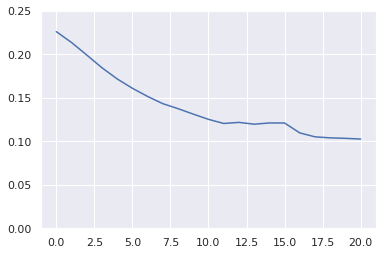

In [ ]:
plt.plot(Results['Cora_icd'])
plt.ylim([0,0.25])